# __Test notebook__

## MSR Testing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import msr_to_matrix, make_system,conjugate_gradient, GetKrylov,GetKrylovw
from scipy.linalg import hessenberg

Matrix:
 [[ 4.  0.  2.  0.]
 [ 0.  8.  0.  4.]
 [ 2.  0.  5. -1.]
 [ 0.  4. -1.  8.]]
Matrix 2:
 [[12. -5.  0.  3.]
 [ 0.  4.  0.  0.]
 [ 0.  0.  2.  0.]
 [ 5. -2. -3. 14.]]


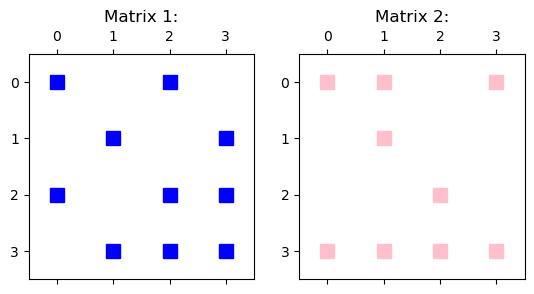

In [2]:
filename = "Data_P1/msr_test_symmetric.txt"; filename2 = "Data_P1/test2.txt" # From MSR_format.pdf
matrix2 = msr_to_matrix(filename2); matrix = msr_to_matrix(filename)

print("Matrix:\n", matrix), print("Matrix 2:\n", matrix2)

plt.subplot(1, 2, 1), plt.spy(matrix, markersize=10, color='b'), plt.title("Matrix 1:")
plt.subplot(1, 2, 2), plt.spy(matrix2, markersize=10, color='pink'), plt.title("Matrix 2:")
plt.show()  # Display the plots

[1. 1. 1. 1.]


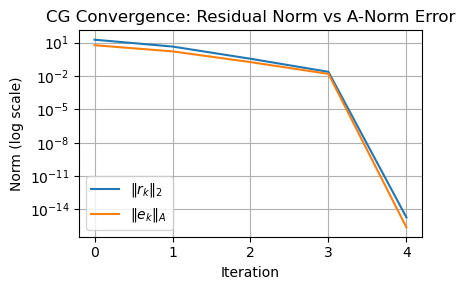

In [3]:
## CG vs Actual results:
tol = 1e-8

A,b,x,x0 = make_system(matrix)
x, r_norms, e_A_norms = conjugate_gradient(matrix, b, x0, x,tol,100 )

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1), plt.semilogy(r_norms, label=r'$\|r_k\|_2$'), plt.semilogy(e_A_norms, label=r'$\|e_k\|_A$'), plt.xlabel('Iteration'), plt.ylabel('Norm (log scale)')
plt.title('CG Convergence: Residual Norm vs A-Norm Error'),plt.legend(), plt.grid(True),plt.tight_layout()
print(x)




## GMRES Testing

1. Restarded GMRES with m =600
2. GMRES with 
* Jacobi 
* GS 
* ILU (0)

In [ ]:
restarting_criteria = 4
A,b,x,x0 = make_system(matrix)

r0 = b - A @ x0
V_0 = r0 / np.linalg.norm(r0)
e_1 = np.zeros((restarting_criteria+1,1)); e_1[0] = 1 # e_1 definition
g_0 = np.linalg.norm(r0) * e_1
#-------- Variable init
V = [V_0]  # Initialize V as a list containing V_0
h = []  # Initialize h as an empty list
r = [r0]  # Initialize r as list containing r0
g = [g_0]  # Initialize g as a list containing g_0
#----------
V_j, H_j = GetKrylovw(A, V_0, restarting_criteria)  # Pass the entire V_0 vector
#for j in range(restarting_criteria):
#    for k in range(2,j):


In [18]:
k = 4
V_k = V_j[:, :k] 
V_kplus1 = V_j[:, :k+1]
H_k = H_j[:k+1, :k]   
residual = A @ V_k - V_kplus1 @ H_k
error = np.linalg.norm(residual)

print("Error: ||A V_k - V_{k+1} H_k|| =", error)

Error: ||A V_k - V_{k+1} H_k|| = 1.368774871883577e-15
